In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [5]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [6]:
customers = pd.read_csv('/Users/shreyas/Desktop/untitled folder/ecommerce_analysis/data/Customers.csv')
transactions = pd.read_csv('/Users/shreyas/Desktop/untitled folder/ecommerce_analysis/data/Transactions.csv')

In [7]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [8]:
merged_data = transactions.merge(customers, on='CustomerID', how='inner')

In [9]:
customer_data = merged_data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    signup_year=('SignupDate', lambda x: x.dt.year.mode()[0]) 
).reset_index()

In [10]:
customer_data = customer_data.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='inner')

In [11]:
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [12]:
scaler = StandardScaler()
numerical_features = ['total_spend', 'transaction_count', 'avg_transaction_value', 'signup_year']
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])


In [13]:
features = customer_data.drop(columns=['CustomerID'])

In [14]:
inertia = []
for k in range(2, 11):  # Test cluster sizes from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

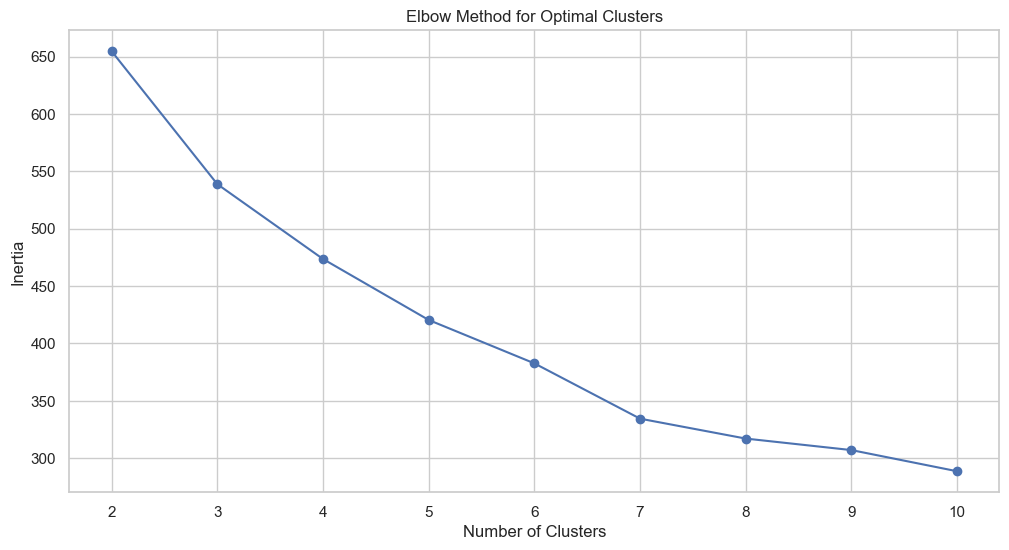

In [15]:
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [16]:
optimal_clusters = 4

In [17]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

In [18]:
customer_data['Cluster'] = clusters

In [19]:
db_index = davies_bouldin_score(features, clusters)
silhouette_avg = silhouette_score(features, clusters)

In [20]:
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")

Davies-Bouldin Index: 1.42
Silhouette Score: 0.22


In [21]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

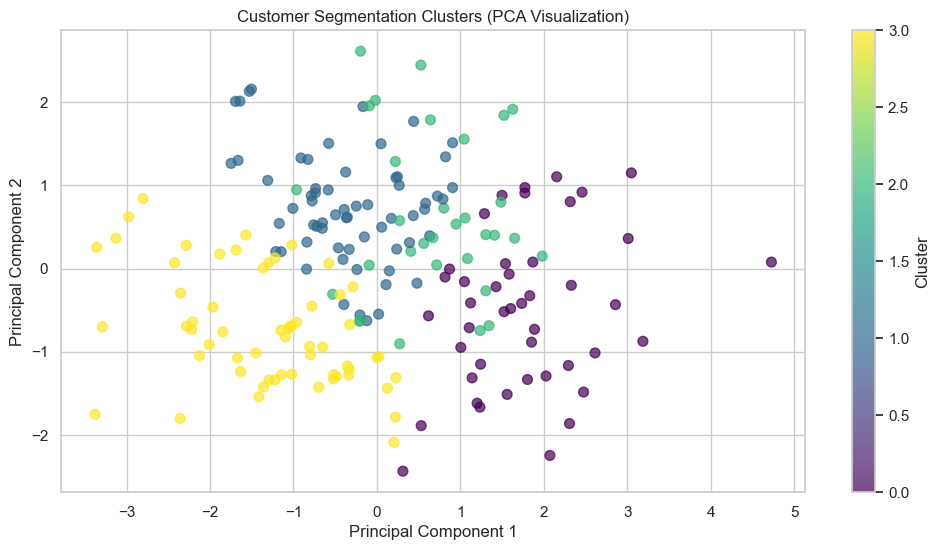

In [22]:
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("Customer Segmentation Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [30]:
numeric_columns = ['total_spend', 'transaction_count', 'avg_transaction_value', 'signup_year']  # Exclude 'CustomerID' and 'Cluster'
cluster_summary = customer_data[numeric_columns + ['Cluster']].groupby('Cluster').mean()
print("\nCluster Analysis:")
print(cluster_summary)



Cluster Analysis:
         total_spend  transaction_count  avg_transaction_value  signup_year
Cluster                                                                    
0           1.284803           1.356650               0.203499    -0.223859
1          -0.271077          -0.148993              -0.074786     0.925889
2           0.437588          -0.339234               1.375950    -0.274329
3          -0.890938          -0.657509              -0.804547    -0.661712


In [26]:
customer_data.to_csv('/Users/shreyas/Desktop/untitled folder/ecommerce_analysis/outputs/shreyas_kulkarni_clustering.csv', index=False)